# 102 category flower classification using ResNet50

## Data Loading

In [1]:
import os
from pathlib import Path
import scipy

### Define Data Paths
We set paths to the data directory and metadata files (label and split files).

In [2]:
# Set path to data directory
data_dir = Path("/kaggle/input/102-flowers")

# Set path to label files & split files
label_file = data_dir / "imagelabels.mat"
split_file = data_dir / "setid.mat" 

### Load Dataset Metadata
We'll load the `.mat` files containig the labels and train/test splits using `scipy.io.loadmat()`.

In [3]:
labels_data = scipy.io.loadmat(label_file)
splits_data = scipy.io.loadmat(split_file)

labels_data, splits_data

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
  '__version__': '1.0',
  '__globals__': [],
  'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)},
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
  '__version__': '1.0',
  '__globals__': [],
  'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
  'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
  'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)})

### Extract label and split indices
We'll extract the 102 labels of the flower and the indices of the images which define which images belong to which split (train/test).

In [4]:
labels = labels_data['labels'].flatten()
train_indices = splits_data['trnid'].flatten()
test_indices = splits_data['tstid'].flatten()
val_indices = splits_data['valid'].flatten()

print(f'First five labels: {labels[:5]}')
print(f'Min value of train_indices: {train_indices.min()}')
print(f'Min value of test_indices: {test_indices.min()}')
print(f'Min value of val_indices: {val_indices.min()}')
print()
print(f'Length of train_indices: {len(train_indices)}')
print(f'Length of test_indices: {len(test_indices)}')
print(f'Length of val_indices: {len(val_indices)}')

First five labels: [77 77 77 77 77]
Min value of train_indices: 28
Min value of test_indices: 1
Min value of val_indices: 17

Length of train_indices: 1020
Length of test_indices: 6149
Length of val_indices: 1020


### Map indices to Image Path

In [5]:
# Load and sort all the image files
data_path = data_dir / "images/images"
images_files = sorted(list(data_path.glob("*.jpg")))

images_files[:5]

[PosixPath('/kaggle/input/102-flowers/images/images/image_00001.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00002.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00003.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00004.jpg'),
 PosixPath('/kaggle/input/102-flowers/images/images/image_00005.jpg')]

## Data Preprocessing

In [6]:
# Create lists of image paths and corresponding labels for the training set.
# i-1 adjustment is done for matching the indices from matlab to python's zero based system
train_images = [images_files[i-1] for i in train_indices]  
train_labels = [labels[i-1] for i in train_indices]

test_images = [images_files[i-1] for i in test_indices]
test_labels = [labels[i-1] for i in test_indices]


val_images = [images_files[i-1] for i in val_indices]
val_labels = [labels[i-1] for i in val_indices]

# Checking the data
print(f'Min train_images value: {min(train_images)}')
print(f'Min test_values: {min(test_images)}')
print(f'Min val_values: {min(val_images)}')
print()
print(f'Length of train_images: {len(train_images)}')
print(f'Length of test_images {len(test_images)}')
print(f'Length of val_images: {len(val_images)}')

Min train_images value: /kaggle/input/102-flowers/images/images/image_00028.jpg
Min test_values: /kaggle/input/102-flowers/images/images/image_00001.jpg
Min val_values: /kaggle/input/102-flowers/images/images/image_00017.jpg

Length of train_images: 1020
Length of test_images 6149
Length of val_images: 1020


### Define Transformations
We use the standard preprocessing transformations for ResNet50, including resizing, cropping, and normalization.

In [7]:
import torch
from torchvision import transforms
from torchvision import models

# Load pretrained weights for ResNet50
pretrained_weights = models.ResNet50_Weights.DEFAULT

# Define the common transforms for input data
common_transforms = pretrained_weights.transforms()
common_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
# Define train and test transformations

train_transform = transforms.Compose([
    transforms.Resize(common_transforms.resize_size),  # Resize to 232
    transforms.RandomCrop(common_transforms.crop_size, padding=4),  # Mild crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduced rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Milder color changes
    transforms.ToTensor(),
    transforms.Normalize(mean=common_transforms.mean, std=common_transforms.std)
])

val_test_transform = transforms.Compose([
    transforms.Resize([232]),
    transforms.CenterCrop([224]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=common_transforms.mean,
        std=common_transforms.std
    )
])

print(train_transform)
print(val_test_transform)

Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.05, 0.05))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=[232], interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Create custom Dataset Class

This class defines a custom dataset for PyTorch, inheriting from `torch.utils.data.Dataset`. It is designed to handle various data formats (e.g., images, features, etc.) and their corresponding labels. 

#### Key Components:
1. **`__init__(self, data, labels, transform=None)`**:
   - Initializes the dataset with input data, labels, and an optional transform function.
2. **`__len__(self)`**:
   - Returns the total number of samples in the dataset.
3. **`__getitem__(self, idx)`**:
   - Retrieves a specific data sample and its corresponding label by index.
   - Optionally applies a transform to the data sample.

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_path, labels, transform=None):  # Make transform optional
        self.data_path = data_path
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, idx: int):
        img = Image.open(self.data_path[idx])

        if self.transform:
            img = self.transform(img)  # Apply transformation only if provided

        img.requires_grad = True

        label = self.labels[idx] - 1  # Assuming labels are 1-indexed
        return img, label
        
    def __len__(self):
        return len(self.data_path)

   

train_dataset = CustomDataset(train_images, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_images, val_labels, transform=val_test_transform)
test_dataset = CustomDataset(test_images, test_labels, val_test_transform)

print(f'Length of train_dataset: {len(train_dataset)}')
print(f'Length of test_dataset {len(test_dataset)}')
print(f'Length of val_dataset: {len(val_dataset)}')

Length of train_dataset: 1020
Length of test_dataset 6149
Length of val_dataset: 1020


### Visualize the data

In [10]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# function to plot transformerd images
def plot_transformed_images(image_paths, labels, transform, n=3, seed=None):
    # Use the seed if mentioned
    if seed:
        random.seed(seed)

    # Create a tuple of image paths and the respective labels of the images
    data = list(zip(image_paths, labels))

    # Select random images
    random_image_paths = random.sample(data, k=n)
    for image in random_image_paths: # iterate through each image 
        img, y = image               # unpack the image and label
        with Image.open(img) as f:
            # Create a subplot of 2 images one for original and other for transformed image 
            fig, ax = plt.subplots(1, 2)

            # Visualize the original Image
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Visualize the transformed image
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            # Mention the respective class of the image
            fig.suptitle(f"Class: {y}", fontsize=16)

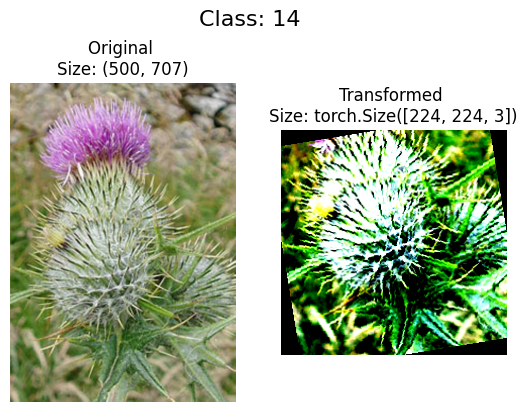

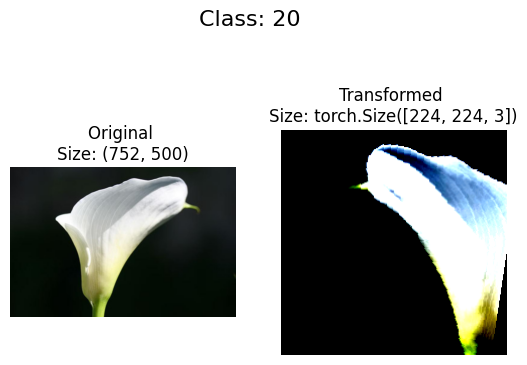

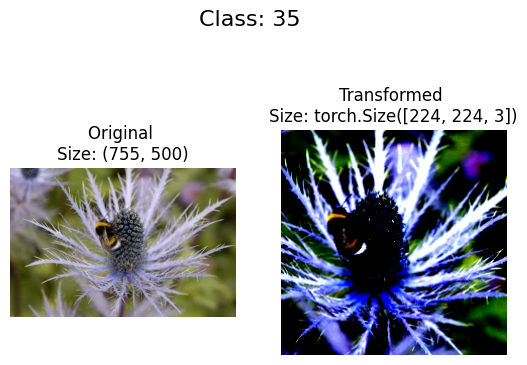

In [11]:
# Plot the original vs transformed image
plot_transformed_images(train_images, train_labels, transform=train_transform, n=3)

In [12]:
# Change the device to cuda if available
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.device_count()


1

## Train/Test functions

In [13]:

import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for training only
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task='multiclass', num_classes=102).to(device)

# Metrics for multiclass classification (macro average)
from torchmetrics.functional import accuracy, precision, recall, f1_score

def compute_metrics(preds, targets):
    acc = accuracy(preds, targets, task='multiclass', num_classes=102, average='micro')
    prec = precision(preds, targets, task='multiclass', num_classes=102, average='macro')
    rec = recall(preds, targets, task='multiclass', num_classes=102, average='macro')
    f1 = f1_score(preds, targets, task='multiclass', num_classes=102, average='macro')
    return {
        'accuracy': acc.item(),
        'precision': prec.item(),
        'recall': rec.item(),
        'f1': f1.item()
    }

# Train function
def train_model(model, dataloader, optimizer, criterion, acc_fn, device):
    # 0. Set the model to train mode
    model.train()
    
    # Initialize loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Iterate throught the data
    for X, y in dataloader:
        # Move the data to the current device
        X, y = X.to(device), y.long().to(device)
        
        # 1. Forward Propagation
        y_hat = model(X)
        
        # 2. Calculate the loss
        loss = criterion(y_hat, y)
        train_loss += loss.item()

        # Calculate accuracy
        y_preds = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        acc = acc_fn(y_preds, y)
        train_acc += acc

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Back Propagation
        loss.backward()

        # 5. Step the optimizer
        optimizer.step()

    # Calcuate and return average loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


# Test Function
def val_model(model, dataloader, criterion, device, compute_metrics_fn):
    model.eval()
    val_loss, val_acc, val_prec, val_rec, val_f1 = 0, 0, 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.long().to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            val_loss += loss.item()

            preds = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)

            metrics = compute_metrics_fn(preds, y)
            val_acc += metrics['accuracy']
            val_prec += metrics['precision']
            val_rec += metrics['recall']
            val_f1 += metrics['f1']

    n = len(dataloader)
    val_loss = val_loss / n
    val_acc = val_acc / n
    val_prec = val_prec / n
    val_rec = val_rec / n
    val_f1 = val_f1 / n
    return (
        val_loss,
        val_acc, 
        val_prec, 
        val_rec, 
        val_f1
    )

    
    
# Evaluation Function
def eval_model(model, dataloader, criterion, device, compute_metrics_fn):
    model.eval()
    test_loss, test_acc, test_prec, test_rec, test_f1 = 0, 0, 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.long().to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item()

            preds = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)

            metrics = compute_metrics_fn(preds, y)
            test_acc += metrics['accuracy']
            test_prec += metrics['precision']
            test_rec += metrics['recall']
            test_f1 += metrics['f1']

    n = len(dataloader)
    return {
        'loss': test_loss / n,
        'accuracy': test_acc / n,
        'precision': test_prec / n,
        'recall': test_rec / n,
        'f1': test_f1 / n
    }

## Hyperparameter Tuning 

### Optuna Objective

In [15]:

import torch.nn as nn 
import torch.optim as optim 
import optuna 
from optuna.exceptions import TrialPruned
from torch.utils.data import DataLoader
from torchvision import models 
from tqdm.auto import tqdm
import copy

def objective(trial): 
    # Sample hyperparameters 
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    momentum = trial.suggest_float("momentum", 0.85, 0.99) if optimizer_name == "SGD" else None
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32]) 
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

    # Create dataloaders with suggested batch_size
    train_loader_opt = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    val_loader_opt = DataLoader(val_dataset, batch_size=batch_size)

    # Load the ResNet50 model with pretrained weights 
    model = models.resnet50(weights=pretrained_weights)
    
    # Replace the final fully connected layer to output 102 classes
    num_classes = 102
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    model = model.to(device) 

    # Loss and optimizer 
    criterion = nn.CrossEntropyLoss() 
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

    # Early stopping parameters
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    epochs_no_improve = 0
    PATIENCE = 3

    # Training loop
    epochs = 15
    print("Training ....")
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = train_model(
            model=model, 
            dataloader=train_loader_opt, 
            optimizer=optimizer, 
            criterion=criterion, 
            acc_fn=accuracy_fn, 
            device=device
        )
        
        model.eval()
        val_loss, val_acc, val_prec, val_rec, val_f1 = val_model(
            model=model,
            dataloader=val_loader_opt,
            criterion=criterion,
            device=device,
            compute_metrics_fn=compute_metrics
        )

        print(
            f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}"
        )

        # Report intermediate value for Optuna
        trial.report(val_f1, epoch)

        # Check Optuna pruning
        if trial.should_prune():
            print("Trial pruned by Optuna")
            raise TrialPruned()

        # Check early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print("✅ Improved F1, saving model")
        else:
            epochs_no_improve += 1
            print(f"❌ No improvement for {epochs_no_improve} epochs")

        if epochs_no_improve >= PATIENCE:
            print("⛔ Early stopping triggered")
            break

        scheduler.step()

    return best_f1


### Run study 

In [17]:

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
)
study.optimize(objective, n_trials=35)

print("Best trial:") 
print("F1 Score:", study.best_trial.value) 
print(" Params:") 
for key, value in study.best_trial.params.items(): 
    print(f" {key}: {value}")


[I 2025-07-27 09:25:26,705] A new study created in memory with name: no-name-a92a032b-1d9b-468d-96eb-d16bc4971c59


Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.4867 | Train Acc: 0.0931 | Val Loss: 4.1719 | Val Acc: 0.3330 | Precision: 0.2045 | Recall: 0.0961 | F1: 0.1197
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.9388 | Train Acc: 0.5684 | Val Loss: 3.7711 | Val Acc: 0.6201 | Precision: 0.3598 | Recall: 0.2641 | F1: 0.2938
✅ Improved F1, saving model
Epoch 2 | Train Loss: 3.5050 | Train Acc: 0.7738 | Val Loss: 3.4210 | Val Acc: 0.7035 | Precision: 0.4452 | Recall: 0.3614 | F1: 0.3880
✅ Improved F1, saving model
Epoch 3 | Train Loss: 3.1595 | Train Acc: 0.8519 | Val Loss: 3.1233 | Val Acc: 0.7331 | Precision: 0.4576 | Recall: 0.3743 | F1: 0.4020
✅ Improved F1, saving model
Epoch 4 | Train Loss: 2.8374 | Train Acc: 0.8900 | Val Loss: 2.8934 | Val Acc: 0.7585 | Precision: 0.4730 | Recall: 0.3928 | F1: 0.4203
✅ Improved F1, saving model
Epoch 5 | Train Loss: 2.5874 | Train Acc: 0.9170 | Val Loss: 2.7894 | Val Acc: 0.7575 | Precision: 0.4872 | Recall: 0.4103 | F1: 0.4373
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 09:30:51,788] Trial 0 finished with value: 0.47603357560001314 and parameters: {'lr': 0.00035510257070475146, 'optimizer': 'Adam', 'batch_size': 16, 'weight_decay': 0.001012634617343852}. Best is trial 0 with value: 0.47603357560001314.


Epoch 13 | Train Loss: 1.9203 | Train Acc: 0.9596 | Val Loss: 2.2454 | Val Acc: 0.7780 | Precision: 0.5034 | Recall: 0.4305 | F1: 0.4561
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.2593 | Train Acc: 0.1667 | Val Loss: 3.4537 | Val Acc: 0.6062 | Precision: 0.3288 | Recall: 0.2313 | F1: 0.2588
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.8502 | Train Acc: 0.8051 | Val Loss: 2.6232 | Val Acc: 0.7447 | Precision: 0.4195 | Recall: 0.3364 | F1: 0.3634
✅ Improved F1, saving model
Epoch 2 | Train Loss: 2.0609 | Train Acc: 0.9060 | Val Loss: 2.1821 | Val Acc: 0.7907 | Precision: 0.4499 | Recall: 0.3800 | F1: 0.4041
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.6038 | Train Acc: 0.9322 | Val Loss: 1.9092 | Val Acc: 0.8104 | Precision: 0.4763 | Recall: 0.4130 | F1: 0.4353
✅ Improved F1, saving model
Epoch 4 | Train Loss: 1.2956 | Train Acc: 0.9598 | Val Loss: 1.7211 | Val Acc: 0.8280 | Precision: 0.5038 | Recall: 0.4433 | F1: 0.4646
✅ Improved F1, saving model
Epoch 5 | Train Loss: 1.1379 | Train Acc: 0.9754 | Val Loss: 1.6688 | Val Acc: 0.8348 | Precision: 0.5204 | Recall: 0.4579 | F1: 0.4799
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 09:34:58,007] Trial 1 finished with value: 0.5069200694561005 and parameters: {'lr': 0.001638775081804742, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.0035229220749366337}. Best is trial 1 with value: 0.5069200694561005.


Epoch 10 | Train Loss: 0.8853 | Train Acc: 0.9912 | Val Loss: 1.4743 | Val Acc: 0.8465 | Precision: 0.5355 | Recall: 0.4746 | F1: 0.4965
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6218 | Train Acc: 0.0117 | Val Loss: 4.5920 | Val Acc: 0.0166 | Precision: 0.0152 | Recall: 0.0037 | F1: 0.0057
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.5708 | Train Acc: 0.0195 | Val Loss: 4.5500 | Val Acc: 0.0283 | Precision: 0.0272 | Recall: 0.0078 | F1: 0.0115
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.5318 | Train Acc: 0.0410 | Val Loss: 4.5079 | Val Acc: 0.0518 | Precision: 0.0491 | Recall: 0.0125 | F1: 0.0191
✅ Improved F1, saving model
Epoch 3 | Train Loss: 4.4925 | Train Acc: 0.0771 | Val Loss: 4.4853 | Val Acc: 0.0840 | Precision: 0.0727 | Recall: 0.0214 | F1: 0.0314
✅ Improved F1, saving model
Epoch 4 | Train Loss: 4.4588 | Train Acc: 0.1182 | Val Loss: 4.4569 | Val Acc: 0.1172 | Precision: 0.0922 | Recall: 0.0288 | F1: 0.0416
✅ Improved F1, saving model
Epoch 5 | Train Loss: 4.4275 | Train Acc: 0.1670 | Val Loss: 4.4260 | Val Acc: 0.1211 | Precision: 0.0954 | Recall: 0.0323 | F1: 0.0455
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 09:41:01,492] Trial 2 finished with value: 0.10630697327724192 and parameters: {'lr': 2.2686922994877617e-05, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.00012857764304572564}. Best is trial 1 with value: 0.5069200694561005.


Epoch 14 | Train Loss: 4.3196 | Train Acc: 0.3467 | Val Loss: 4.3272 | Val Acc: 0.2715 | Precision: 0.1829 | Recall: 0.0795 | F1: 0.1034
❌ No improvement for 1 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6320 | Train Acc: 0.0137 | Val Loss: 4.6250 | Val Acc: 0.0146 | Precision: 0.0108 | Recall: 0.0026 | F1: 0.0040
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.6216 | Train Acc: 0.0088 | Val Loss: 4.6151 | Val Acc: 0.0176 | Precision: 0.0139 | Recall: 0.0038 | F1: 0.0056
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.6069 | Train Acc: 0.0137 | Val Loss: 4.6014 | Val Acc: 0.0225 | Precision: 0.0189 | Recall: 0.0055 | F1: 0.0081
✅ Improved F1, saving model
Epoch 3 | Train Loss: 4.5977 | Train Acc: 0.0195 | Val Loss: 4.5928 | Val Acc: 0.0283 | Precision: 0.0235 | Recall: 0.0061 | F1: 0.0092
✅ Improved F1, saving model
Epoch 4 | Train Loss: 4.5821 | Train Acc: 0.0332 | Val Loss: 4.5803 | Val Acc: 0.0303 | Precision: 0.0241 | Recall: 0.0068 | F1: 0.0100
✅ Improved F1, saving model
Epoch 5 | Train Loss: 4.5745 | Train Acc: 0.0371 | Val Loss: 4.5743 | Val Acc: 0.0322 | Precision: 0.0268 | Recall: 0.0079 | F1: 0.0115
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 09:47:07,721] Trial 3 finished with value: 0.026936532187392004 and parameters: {'lr': 1.7308614834411828e-05, 'optimizer': 'SGD', 'momentum': 0.9825719777913855, 'batch_size': 8, 'weight_decay': 1.0616270235323839e-05}. Best is trial 1 with value: 0.5069200694561005.


Epoch 14 | Train Loss: 4.5339 | Train Acc: 0.0791 | Val Loss: 4.5365 | Val Acc: 0.0693 | Precision: 0.0528 | Recall: 0.0185 | F1: 0.0257
❌ No improvement for 1 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6237 | Train Acc: 0.0117 | Val Loss: 4.6197 | Val Acc: 0.0088 | Precision: 0.0081 | Recall: 0.0016 | F1: 0.0025
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.6223 | Train Acc: 0.0138 | Val Loss: 4.6196 | Val Acc: 0.0107 | Precision: 0.0092 | Recall: 0.0019 | F1: 0.0030
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.6233 | Train Acc: 0.0117 | Val Loss: 4.6187 | Val Acc: 0.0128 | Precision: 0.0134 | Recall: 0.0022 | F1: 0.0035
✅ Improved F1, saving model
Epoch 3 | Train Loss: 4.6222 | Train Acc: 0.0127 | Val Loss: 4.6183 | Val Acc: 0.0119 | Precision: 0.0121 | Recall: 0.0021 | F1: 0.0033
❌ No improvement for 1 epochs
Epoch 4 | Train Loss: 4.6242 | Train Acc: 0.0137 | Val Loss: 4.6178 | Val Acc: 0.0138 | Precision: 0.0147 | Recall: 0.0025 | F1: 0.0040
✅ Improved F1, saving model
Epoch 5 | Train Loss: 4.6185 | Train Acc: 0.0117 | Val Loss: 4.6168 | Val Acc: 0.0138 | Precision: 0.0143 | Recall: 0.0024 | F1: 0.0039
❌ No improvement for 1 epochs
Epoch 6 | Tr

[I 2025-07-27 09:50:08,346] Trial 4 finished with value: 0.003981630434282124 and parameters: {'lr': 1.2872646045492207e-05, 'optimizer': 'SGD', 'momentum': 0.9115957182044508, 'batch_size': 32, 'weight_decay': 0.0008316755778094406}. Best is trial 1 with value: 0.5069200694561005.


Epoch 7 | Train Loss: 4.6193 | Train Acc: 0.0127 | Val Loss: 4.6164 | Val Acc: 0.0138 | Precision: 0.0136 | Recall: 0.0024 | F1: 0.0039
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6239 | Train Acc: 0.0107 | Val Loss: 4.6238 | Val Acc: 0.0127 | Precision: 0.0109 | Recall: 0.0021 | F1: 0.0034
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.6262 | Train Acc: 0.0098 | Val Loss: 4.6235 | Val Acc: 0.0127 | Precision: 0.0112 | Recall: 0.0024 | F1: 0.0038
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.6221 | Train Acc: 0.0117 | Val Loss: 4.6210 | Val Acc: 0.0146 | Precision: 0.0124 | Recall: 0.0020 | F1: 0.0034
❌ No improvement for 1 epochs


[I 2025-07-27 09:51:40,730] Trial 5 pruned. 


Epoch 3 | Train Loss: 4.6176 | Train Acc: 0.0107 | Val Loss: 4.6189 | Val Acc: 0.0137 | Precision: 0.0115 | Recall: 0.0026 | F1: 0.0040
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6329 | Train Acc: 0.0068 | Val Loss: 4.6236 | Val Acc: 0.0117 | Precision: 0.0109 | Recall: 0.0028 | F1: 0.0042
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.6315 | Train Acc: 0.0098 | Val Loss: 4.6219 | Val Acc: 0.0117 | Precision: 0.0133 | Recall: 0.0028 | F1: 0.0044
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.6282 | Train Acc: 0.0107 | Val Loss: 4.6211 | Val Acc: 0.0078 | Precision: 0.0085 | Recall: 0.0022 | F1: 0.0033
❌ No improvement for 1 epochs


[I 2025-07-27 09:53:18,351] Trial 6 pruned. 


Epoch 3 | Train Loss: 4.6269 | Train Acc: 0.0107 | Val Loss: 4.6185 | Val Acc: 0.0107 | Precision: 0.0109 | Recall: 0.0028 | F1: 0.0042
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.5456 | Train Acc: 0.2983 | Val Loss: 1.7046 | Val Acc: 0.6479 | Precision: 0.3554 | Recall: 0.2616 | F1: 0.2892
✅ Improved F1, saving model
Epoch 1 | Train Loss: 0.7798 | Train Acc: 0.8813 | Val Loss: 1.0242 | Val Acc: 0.7909 | Precision: 0.4545 | Recall: 0.3759 | F1: 0.4031
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.3462 | Train Acc: 0.9637 | Val Loss: 0.8741 | Val Acc: 0.8124 | Precision: 0.4829 | Recall: 0.4107 | F1: 0.4357
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.2219 | Train Acc: 0.9844 | Val Loss: 0.7874 | Val Acc: 0.8298 | Precision: 0.5161 | Recall: 0.4468 | F1: 0.4711
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.1717 | Train Acc: 0.9873 | Val Loss: 0.7540 | Val Acc: 0.8378 | Precision: 0.5258 | Recall: 0.4560 | F1: 0.4822
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.1298 | Train Acc: 0.9980 | Val Loss: 0.6969 | Val Acc: 0.8622 | Precision: 0.5426 | Recall: 0.4825 | F1: 0.5059
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 09:58:12,458] Trial 7 finished with value: 0.5453544724732637 and parameters: {'lr': 0.007270685260143014, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.0002453640814296799}. Best is trial 7 with value: 0.5453544724732637.


Epoch 12 | Train Loss: 0.0918 | Train Acc: 0.9990 | Val Loss: 0.6730 | Val Acc: 0.8700 | Precision: 0.5574 | Recall: 0.4961 | F1: 0.5194
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.5902 | Train Acc: 0.0342 | Val Loss: 4.4787 | Val Acc: 0.0854 | Precision: 0.0600 | Recall: 0.0201 | F1: 0.0266
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.3899 | Train Acc: 0.2239 | Val Loss: 4.3404 | Val Acc: 0.2552 | Precision: 0.1560 | Recall: 0.0605 | F1: 0.0794
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.2170 | Train Acc: 0.4675 | Val Loss: 4.2042 | Val Acc: 0.4138 | Precision: 0.2282 | Recall: 0.1194 | F1: 0.1470
✅ Improved F1, saving model


[I 2025-07-27 09:59:42,681] Trial 8 pruned. 


Epoch 3 | Train Loss: 4.0781 | Train Acc: 0.6392 | Val Loss: 4.0823 | Val Acc: 0.5057 | Precision: 0.2736 | Recall: 0.1606 | F1: 0.1910
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6277 | Train Acc: 0.0179 | Val Loss: 4.6235 | Val Acc: 0.0137 | Precision: 0.0091 | Recall: 0.0026 | F1: 0.0038
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.6208 | Train Acc: 0.0195 | Val Loss: 4.6172 | Val Acc: 0.0160 | Precision: 0.0110 | Recall: 0.0034 | F1: 0.0047
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.6162 | Train Acc: 0.0225 | Val Loss: 4.6100 | Val Acc: 0.0160 | Precision: 0.0112 | Recall: 0.0029 | F1: 0.0044
❌ No improvement for 1 epochs


[I 2025-07-27 10:01:16,030] Trial 9 pruned. 


Epoch 3 | Train Loss: 4.6020 | Train Acc: 0.0267 | Val Loss: 4.6019 | Val Acc: 0.0195 | Precision: 0.0143 | Recall: 0.0040 | F1: 0.0058
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.4766 | Train Acc: 0.2891 | Val Loss: 1.5792 | Val Acc: 0.6443 | Precision: 0.3573 | Recall: 0.2661 | F1: 0.2937
✅ Improved F1, saving model
Epoch 1 | Train Loss: 0.5930 | Train Acc: 0.8876 | Val Loss: 0.9493 | Val Acc: 0.7821 | Precision: 0.4449 | Recall: 0.3659 | F1: 0.3939
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.2093 | Train Acc: 0.9727 | Val Loss: 0.7876 | Val Acc: 0.8114 | Precision: 0.4928 | Recall: 0.4243 | F1: 0.4481
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.1320 | Train Acc: 0.9881 | Val Loss: 0.7273 | Val Acc: 0.8251 | Precision: 0.5184 | Recall: 0.4517 | F1: 0.4754
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.0982 | Train Acc: 0.9911 | Val Loss: 0.7009 | Val Acc: 0.8329 | Precision: 0.5149 | Recall: 0.4504 | F1: 0.4737
❌ No improvement for 1 epochs
Epoch 5 | Train Loss: 0.0686 | Train Acc: 0.9932 | Val Loss: 0.6859 | Val Acc: 0.8426 | Precision: 0.5294 | Recall: 0.4696 | F1: 0.4908
✅ Improved F1, saving model
Epoch 6 | Trai

[I 2025-07-27 10:05:26,339] Trial 10 finished with value: 0.5033726757392287 and parameters: {'lr': 0.009673895363437284, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 3.0214285145660914e-05}. Best is trial 7 with value: 0.5453544724732637.


Epoch 10 | Train Loss: 0.0356 | Train Acc: 0.9990 | Val Loss: 0.6026 | Val Acc: 0.8495 | Precision: 0.5316 | Recall: 0.4716 | F1: 0.4944
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.6184 | Train Acc: 0.3087 | Val Loss: 2.1699 | Val Acc: 0.6327 | Precision: 0.3800 | Recall: 0.2864 | F1: 0.3115
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.7257 | Train Acc: 0.8069 | Val Loss: 1.8446 | Val Acc: 0.7281 | Precision: 0.4085 | Recall: 0.3337 | F1: 0.3572
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.4022 | Train Acc: 0.8595 | Val Loss: 1.6186 | Val Acc: 0.7711 | Precision: 0.4490 | Recall: 0.3693 | F1: 0.3960
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.1681 | Train Acc: 0.9127 | Val Loss: 1.6024 | Val Acc: 0.7790 | Precision: 0.4570 | Recall: 0.3817 | F1: 0.4078
✅ Improved F1, saving model


[I 2025-07-27 10:07:20,367] Trial 11 pruned. 


Epoch 4 | Train Loss: 1.0766 | Train Acc: 0.9224 | Val Loss: 1.5283 | Val Acc: 0.7860 | Precision: 0.4628 | Recall: 0.3884 | F1: 0.4132
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.2020 | Train Acc: 0.1798 | Val Loss: 3.2459 | Val Acc: 0.6095 | Precision: 0.3148 | Recall: 0.2267 | F1: 0.2541
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.5378 | Train Acc: 0.7994 | Val Loss: 2.3774 | Val Acc: 0.7273 | Precision: 0.4001 | Recall: 0.3160 | F1: 0.3432
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.6657 | Train Acc: 0.9188 | Val Loss: 1.8865 | Val Acc: 0.7840 | Precision: 0.4475 | Recall: 0.3744 | F1: 0.4001
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.2701 | Train Acc: 0.9512 | Val Loss: 1.6611 | Val Acc: 0.8094 | Precision: 0.4764 | Recall: 0.4097 | F1: 0.4337
✅ Improved F1, saving model
Epoch 4 | Train Loss: 1.0232 | Train Acc: 0.9745 | Val Loss: 1.4871 | Val Acc: 0.8280 | Precision: 0.5076 | Recall: 0.4451 | F1: 0.4674
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.8730 | Train Acc: 0.9805 | Val Loss: 1.4286 | Val Acc: 0.8387 | Precision: 0.5185 | Recall: 0.4562 | F1: 0.4787
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 10:13:00,292] Trial 12 finished with value: 0.5117878383025527 and parameters: {'lr': 0.002021022764542737, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.0025716062236770462}. Best is trial 7 with value: 0.5453544724732637.


Epoch 14 | Train Loss: 0.6120 | Train Acc: 0.9961 | Val Loss: 1.2465 | Val Acc: 0.8524 | Precision: 0.5368 | Recall: 0.4767 | F1: 0.4984
❌ No improvement for 2 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.0925 | Train Acc: 0.2019 | Val Loss: 3.0320 | Val Acc: 0.6285 | Precision: 0.3419 | Recall: 0.2387 | F1: 0.2690
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.2598 | Train Acc: 0.8145 | Val Loss: 2.1214 | Val Acc: 0.7281 | Precision: 0.3920 | Recall: 0.3094 | F1: 0.3361
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.4398 | Train Acc: 0.9117 | Val Loss: 1.6984 | Val Acc: 0.7997 | Precision: 0.4717 | Recall: 0.4020 | F1: 0.4249
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.0304 | Train Acc: 0.9590 | Val Loss: 1.4755 | Val Acc: 0.8163 | Precision: 0.4716 | Recall: 0.4050 | F1: 0.4288
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.8395 | Train Acc: 0.9745 | Val Loss: 1.3482 | Val Acc: 0.8368 | Precision: 0.5026 | Recall: 0.4376 | F1: 0.4614
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.7049 | Train Acc: 0.9844 | Val Loss: 1.2991 | Val Acc: 0.8417 | Precision: 0.5147 | Recall: 0.4496 | F1: 0.4734
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 10:17:54,416] Trial 13 finished with value: 0.5063039734959602 and parameters: {'lr': 0.002380855895242399, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.0020986029258640636}. Best is trial 7 with value: 0.5453544724732637.


Epoch 12 | Train Loss: 0.5447 | Train Acc: 0.9971 | Val Loss: 1.1597 | Val Acc: 0.8544 | Precision: 0.5328 | Recall: 0.4710 | F1: 0.4934
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.1251 | Train Acc: 0.1982 | Val Loss: 2.9581 | Val Acc: 0.6180 | Precision: 0.3026 | Recall: 0.2217 | F1: 0.2468
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.0730 | Train Acc: 0.8195 | Val Loss: 1.9164 | Val Acc: 0.7605 | Precision: 0.4295 | Recall: 0.3536 | F1: 0.3785
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.1588 | Train Acc: 0.9344 | Val Loss: 1.4119 | Val Acc: 0.8075 | Precision: 0.4741 | Recall: 0.4048 | F1: 0.4294
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.7411 | Train Acc: 0.9715 | Val Loss: 1.1994 | Val Acc: 0.8241 | Precision: 0.4952 | Recall: 0.4301 | F1: 0.4535
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.5160 | Train Acc: 0.9725 | Val Loss: 1.0527 | Val Acc: 0.8407 | Precision: 0.5099 | Recall: 0.4494 | F1: 0.4718
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.3872 | Train Acc: 0.9932 | Val Loss: 0.9853 | Val Acc: 0.8426 | Precision: 0.5191 | Recall: 0.4586 | F1: 0.4799
✅ Improved F1, saving model


[I 2025-07-27 10:20:31,419] Trial 14 pruned. 


Epoch 6 | Train Loss: 0.3526 | Train Acc: 0.9941 | Val Loss: 0.9484 | Val Acc: 0.8426 | Precision: 0.5107 | Recall: 0.4484 | F1: 0.4705
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.3842 | Train Acc: 0.1279 | Val Loss: 3.7936 | Val Acc: 0.4874 | Precision: 0.2723 | Recall: 0.1613 | F1: 0.1876
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.3070 | Train Acc: 0.7522 | Val Loss: 3.1137 | Val Acc: 0.7028 | Precision: 0.3830 | Recall: 0.2949 | F1: 0.3227
✅ Improved F1, saving model
Epoch 2 | Train Loss: 2.5779 | Train Acc: 0.8800 | Val Loss: 2.6080 | Val Acc: 0.7635 | Precision: 0.4306 | Recall: 0.3538 | F1: 0.3796
✅ Improved F1, saving model


[I 2025-07-27 10:22:01,852] Trial 15 pruned. 


Epoch 3 | Train Loss: 2.0434 | Train Acc: 0.9295 | Val Loss: 2.2375 | Val Acc: 0.7917 | Precision: 0.4492 | Recall: 0.3788 | F1: 0.4032
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.7373 | Train Acc: 0.2564 | Val Loss: 2.1560 | Val Acc: 0.6590 | Precision: 0.3188 | Recall: 0.2381 | F1: 0.2636
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.2254 | Train Acc: 0.8542 | Val Loss: 1.2773 | Val Acc: 0.7836 | Precision: 0.4416 | Recall: 0.3630 | F1: 0.3908
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.5650 | Train Acc: 0.9561 | Val Loss: 1.0181 | Val Acc: 0.8085 | Precision: 0.4806 | Recall: 0.4087 | F1: 0.4343
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.3659 | Train Acc: 0.9754 | Val Loss: 0.8942 | Val Acc: 0.8249 | Precision: 0.4964 | Recall: 0.4281 | F1: 0.4527
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.2512 | Train Acc: 0.9891 | Val Loss: 0.8271 | Val Acc: 0.8397 | Precision: 0.5190 | Recall: 0.4580 | F1: 0.4807
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.1990 | Train Acc: 0.9941 | Val Loss: 0.7785 | Val Acc: 0.8464 | Precision: 0.5113 | Recall: 0.4507 | F1: 0.4737
❌ No improvement for 1 epochs


[I 2025-07-27 10:24:40,111] Trial 16 pruned. 


Epoch 6 | Train Loss: 0.1802 | Train Acc: 0.9990 | Val Loss: 0.7641 | Val Acc: 0.8523 | Precision: 0.5186 | Recall: 0.4582 | F1: 0.4806
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.4732 | Train Acc: 0.0738 | Val Loss: 4.1087 | Val Acc: 0.3982 | Precision: 0.2077 | Recall: 0.1203 | F1: 0.1401
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.8034 | Train Acc: 0.6521 | Val Loss: 3.6416 | Val Acc: 0.6490 | Precision: 0.3587 | Recall: 0.2621 | F1: 0.2892
✅ Improved F1, saving model
Epoch 2 | Train Loss: 3.2595 | Train Acc: 0.8609 | Val Loss: 3.2427 | Val Acc: 0.7176 | Precision: 0.3966 | Recall: 0.3069 | F1: 0.3360
✅ Improved F1, saving model


[I 2025-07-27 10:26:12,047] Trial 17 pruned. 


Epoch 3 | Train Loss: 2.8264 | Train Acc: 0.9040 | Val Loss: 2.9251 | Val Acc: 0.7497 | Precision: 0.4220 | Recall: 0.3444 | F1: 0.3708
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.5829 | Train Acc: 0.0254 | Val Loss: 4.4594 | Val Acc: 0.1104 | Precision: 0.0732 | Recall: 0.0255 | F1: 0.0343
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.3723 | Train Acc: 0.2243 | Val Loss: 4.2990 | Val Acc: 0.3024 | Precision: 0.1683 | Recall: 0.0819 | F1: 0.1027
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.2018 | Train Acc: 0.4857 | Val Loss: 4.1619 | Val Acc: 0.4417 | Precision: 0.2420 | Recall: 0.1377 | F1: 0.1664
✅ Improved F1, saving model


[I 2025-07-27 10:27:45,671] Trial 18 pruned. 


Epoch 3 | Train Loss: 4.0391 | Train Acc: 0.6611 | Val Loss: 4.0223 | Val Acc: 0.5514 | Precision: 0.3123 | Recall: 0.2100 | F1: 0.2405
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.5677 | Train Acc: 0.2744 | Val Loss: 2.0471 | Val Acc: 0.6113 | Precision: 0.4515 | Recall: 0.3632 | F1: 0.3912
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.6947 | Train Acc: 0.7109 | Val Loss: 1.5393 | Val Acc: 0.7217 | Precision: 0.5553 | Recall: 0.4775 | F1: 0.5030
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.2758 | Train Acc: 0.8115 | Val Loss: 1.4026 | Val Acc: 0.7598 | Precision: 0.5840 | Recall: 0.5126 | F1: 0.5362
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.1023 | Train Acc: 0.8740 | Val Loss: 1.2069 | Val Acc: 0.7588 | Precision: 0.5916 | Recall: 0.5139 | F1: 0.5401
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.9348 | Train Acc: 0.9014 | Val Loss: 1.1676 | Val Acc: 0.7988 | Precision: 0.6288 | Recall: 0.5577 | F1: 0.5833
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.7946 | Train Acc: 0.9385 | Val Loss: 1.0383 | Val Acc: 0.8271 | Precision: 0.6403 | Recall: 0.5789 | F1: 0.6021
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 10:31:52,159] Trial 19 finished with value: 0.661743312724866 and parameters: {'lr': 0.004249493971995518, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0025222546952447644}. Best is trial 19 with value: 0.661743312724866.


Epoch 9 | Train Loss: 0.7214 | Train Acc: 0.9580 | Val Loss: 1.0490 | Val Acc: 0.8174 | Precision: 0.6561 | Recall: 0.5938 | F1: 0.6159
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.5071 | Train Acc: 0.2715 | Val Loss: 1.7109 | Val Acc: 0.6650 | Precision: 0.4943 | Recall: 0.3975 | F1: 0.4279
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.2696 | Train Acc: 0.7852 | Val Loss: 1.2116 | Val Acc: 0.7715 | Precision: 0.5924 | Recall: 0.5168 | F1: 0.5423
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.9393 | Train Acc: 0.8691 | Val Loss: 1.1419 | Val Acc: 0.7588 | Precision: 0.5852 | Recall: 0.5101 | F1: 0.5355
❌ No improvement for 1 epochs
Epoch 3 | Train Loss: 0.7293 | Train Acc: 0.9199 | Val Loss: 1.0169 | Val Acc: 0.7949 | Precision: 0.6195 | Recall: 0.5483 | F1: 0.5733
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.6194 | Train Acc: 0.9375 | Val Loss: 0.9940 | Val Acc: 0.7910 | Precision: 0.6128 | Recall: 0.5423 | F1: 0.5671
❌ No improvement for 1 epochs
Epoch 5 | Train Loss: 0.5045 | Train Acc: 0.9697 | Val Loss: 0.8546 | Val Acc: 0.8477 | Precision: 0.6873 | Recall: 0.6271 | F1: 0.6495
✅ Improved F1, saving model
Epoch 6 | Tr

[I 2025-07-27 10:38:01,694] Trial 20 finished with value: 0.6867827511159703 and parameters: {'lr': 0.004472206579434882, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0011546072666839902}. Best is trial 20 with value: 0.6867827511159703.


Epoch 14 | Train Loss: 0.3985 | Train Acc: 0.9883 | Val Loss: 0.8109 | Val Acc: 0.8682 | Precision: 0.7185 | Recall: 0.6642 | F1: 0.6844
❌ No improvement for 1 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.3731 | Train Acc: 0.2861 | Val Loss: 1.6235 | Val Acc: 0.6621 | Precision: 0.4917 | Recall: 0.4018 | F1: 0.4308
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.2417 | Train Acc: 0.7764 | Val Loss: 1.1901 | Val Acc: 0.7646 | Precision: 0.5908 | Recall: 0.5174 | F1: 0.5421
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.7951 | Train Acc: 0.8936 | Val Loss: 1.0510 | Val Acc: 0.8105 | Precision: 0.6344 | Recall: 0.5619 | F1: 0.5882
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.7197 | Train Acc: 0.8994 | Val Loss: 0.9767 | Val Acc: 0.7998 | Precision: 0.6068 | Recall: 0.5408 | F1: 0.5644
❌ No improvement for 1 epochs
Epoch 4 | Train Loss: 0.5989 | Train Acc: 0.9307 | Val Loss: 0.8965 | Val Acc: 0.8232 | Precision: 0.6595 | Recall: 0.5995 | F1: 0.6215
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.4561 | Train Acc: 0.9707 | Val Loss: 0.8088 | Val Acc: 0.8418 | Precision: 0.6801 | Recall: 0.6237 | F1: 0.6443
✅ Improved F1, saving model
Epoch 6 | Trai

[I 2025-07-27 10:43:23,898] Trial 21 finished with value: 0.6882259956619237 and parameters: {'lr': 0.004787766138505749, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0010307571911886265}. Best is trial 21 with value: 0.6882259956619237.


Epoch 12 | Train Loss: 0.3586 | Train Acc: 0.9941 | Val Loss: 0.7581 | Val Acc: 0.8652 | Precision: 0.7086 | Recall: 0.6578 | F1: 0.6771
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.5437 | Train Acc: 0.2803 | Val Loss: 1.9026 | Val Acc: 0.6436 | Precision: 0.4925 | Recall: 0.4039 | F1: 0.4312
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.3844 | Train Acc: 0.7510 | Val Loss: 1.2990 | Val Acc: 0.7461 | Precision: 0.5678 | Recall: 0.4888 | F1: 0.5156
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.9416 | Train Acc: 0.8789 | Val Loss: 1.0680 | Val Acc: 0.7881 | Precision: 0.6196 | Recall: 0.5478 | F1: 0.5730
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.7417 | Train Acc: 0.9111 | Val Loss: 0.9869 | Val Acc: 0.8223 | Precision: 0.6410 | Recall: 0.5812 | F1: 0.6037
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.6304 | Train Acc: 0.9463 | Val Loss: 0.9445 | Val Acc: 0.8281 | Precision: 0.6618 | Recall: 0.6024 | F1: 0.6239
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.5179 | Train Acc: 0.9678 | Val Loss: 0.9506 | Val Acc: 0.8467 | Precision: 0.6738 | Recall: 0.6178 | F1: 0.6394
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 10:49:33,207] Trial 22 finished with value: 0.6907464968389831 and parameters: {'lr': 0.003908109542188833, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0010455926909074692}. Best is trial 22 with value: 0.6907464968389831.


Epoch 14 | Train Loss: 0.3985 | Train Acc: 0.9883 | Val Loss: 0.8073 | Val Acc: 0.8604 | Precision: 0.7002 | Recall: 0.6497 | F1: 0.6692
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.2599 | Train Acc: 0.1533 | Val Loss: 3.4078 | Val Acc: 0.5020 | Precision: 0.3638 | Recall: 0.2595 | F1: 0.2890
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.0096 | Train Acc: 0.6289 | Val Loss: 2.6883 | Val Acc: 0.6670 | Precision: 0.4963 | Recall: 0.4002 | F1: 0.4301
✅ Improved F1, saving model
Epoch 2 | Train Loss: 2.3440 | Train Acc: 0.8232 | Val Loss: 2.1530 | Val Acc: 0.7354 | Precision: 0.5564 | Recall: 0.4700 | F1: 0.4999
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.8641 | Train Acc: 0.8613 | Val Loss: 1.8329 | Val Acc: 0.7725 | Precision: 0.6033 | Recall: 0.5259 | F1: 0.5534
✅ Improved F1, saving model
Epoch 4 | Train Loss: 1.5611 | Train Acc: 0.9111 | Val Loss: 1.6370 | Val Acc: 0.7803 | Precision: 0.6209 | Recall: 0.5456 | F1: 0.5717
✅ Improved F1, saving model
Epoch 5 | Train Loss: 1.3241 | Train Acc: 0.9229 | Val Loss: 1.5250 | Val Acc: 0.7881 | Precision: 0.6068 | Recall: 0.5353 | F1: 0.5610
❌ No improvement for 1 epochs
Epoch 6 | Trai

[I 2025-07-27 10:55:40,924] Trial 23 finished with value: 0.6336510056862608 and parameters: {'lr': 0.0008155651364765015, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0010162749003992143}. Best is trial 22 with value: 0.6907464968389831.


Epoch 14 | Train Loss: 0.8488 | Train Acc: 0.9658 | Val Loss: 1.1736 | Val Acc: 0.8389 | Precision: 0.6658 | Recall: 0.6058 | F1: 0.6286
❌ No improvement for 2 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.4700 | Train Acc: 0.2754 | Val Loss: 1.8429 | Val Acc: 0.6250 | Precision: 0.4523 | Recall: 0.3627 | F1: 0.3907
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.3969 | Train Acc: 0.7666 | Val Loss: 1.3760 | Val Acc: 0.7305 | Precision: 0.5612 | Recall: 0.4798 | F1: 0.5063
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.9965 | Train Acc: 0.8779 | Val Loss: 1.1587 | Val Acc: 0.7832 | Precision: 0.6023 | Recall: 0.5302 | F1: 0.5552
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.8091 | Train Acc: 0.8906 | Val Loss: 1.0533 | Val Acc: 0.8076 | Precision: 0.6391 | Recall: 0.5754 | F1: 0.5979
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.6951 | Train Acc: 0.9365 | Val Loss: 0.9635 | Val Acc: 0.8242 | Precision: 0.6660 | Recall: 0.6013 | F1: 0.6250
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.5453 | Train Acc: 0.9648 | Val Loss: 0.8705 | Val Acc: 0.8545 | Precision: 0.6804 | Recall: 0.6267 | F1: 0.6479
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:01:45,132] Trial 24 finished with value: 0.6883865645504557 and parameters: {'lr': 0.004105211355139921, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0013079355687922877}. Best is trial 22 with value: 0.6907464968389831.


Epoch 14 | Train Loss: 0.4082 | Train Acc: 0.9902 | Val Loss: 0.7992 | Val Acc: 0.8672 | Precision: 0.6985 | Recall: 0.6452 | F1: 0.6662
❌ No improvement for 2 epochs
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.1255 | Train Acc: 0.1846 | Val Loss: 2.9482 | Val Acc: 0.5986 | Precision: 0.4270 | Recall: 0.3236 | F1: 0.3546
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.4973 | Train Acc: 0.7031 | Val Loss: 2.1292 | Val Acc: 0.7139 | Precision: 0.5161 | Recall: 0.4294 | F1: 0.4587
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.7733 | Train Acc: 0.8447 | Val Loss: 1.6659 | Val Acc: 0.7578 | Precision: 0.5766 | Recall: 0.4999 | F1: 0.5266
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.3235 | Train Acc: 0.8818 | Val Loss: 1.4183 | Val Acc: 0.8105 | Precision: 0.6412 | Recall: 0.5743 | F1: 0.5986
✅ Improved F1, saving model
Epoch 4 | Train Loss: 1.0941 | Train Acc: 0.9219 | Val Loss: 1.2682 | Val Acc: 0.8154 | Precision: 0.6345 | Recall: 0.5677 | F1: 0.5922
❌ No improvement for 1 epochs
Epoch 5 | Train Loss: 0.9070 | Train Acc: 0.9492 | Val Loss: 1.1680 | Val Acc: 0.8271 | Precision: 0.6528 | Recall: 0.5909 | F1: 0.6142
✅ Improved F1, saving model
Epoch 6 | Trai

[I 2025-07-27 11:07:02,708] Trial 25 finished with value: 0.6654066286282614 and parameters: {'lr': 0.0012067962674378251, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0006519254629232179}. Best is trial 22 with value: 0.6907464968389831.


Epoch 12 | Train Loss: 0.5763 | Train Acc: 0.9805 | Val Loss: 0.9487 | Val Acc: 0.8506 | Precision: 0.6905 | Recall: 0.6344 | F1: 0.6557
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.5707 | Train Acc: 0.0410 | Val Loss: 4.4044 | Val Acc: 0.2441 | Precision: 0.1579 | Recall: 0.0835 | F1: 0.1014
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.3373 | Train Acc: 0.3018 | Val Loss: 4.1794 | Val Acc: 0.4189 | Precision: 0.3090 | Recall: 0.2023 | F1: 0.2300
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.1118 | Train Acc: 0.4922 | Val Loss: 3.9707 | Val Acc: 0.5303 | Precision: 0.3674 | Recall: 0.2572 | F1: 0.2900
✅ Improved F1, saving model


[I 2025-07-27 11:08:41,778] Trial 26 pruned. 


Epoch 3 | Train Loss: 3.9112 | Train Acc: 0.5859 | Val Loss: 3.7796 | Val Acc: 0.5898 | Precision: 0.4273 | Recall: 0.3218 | F1: 0.3527
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.4871 | Train Acc: 0.0742 | Val Loss: 4.0614 | Val Acc: 0.3887 | Precision: 0.2678 | Recall: 0.1852 | F1: 0.2089
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.8492 | Train Acc: 0.5000 | Val Loss: 3.5834 | Val Acc: 0.6191 | Precision: 0.4425 | Recall: 0.3482 | F1: 0.3776
✅ Improved F1, saving model
Epoch 2 | Train Loss: 3.4235 | Train Acc: 0.7188 | Val Loss: 3.2045 | Val Acc: 0.7031 | Precision: 0.5220 | Recall: 0.4328 | F1: 0.4628
✅ Improved F1, saving model
Epoch 3 | Train Loss: 3.0816 | Train Acc: 0.7871 | Val Loss: 2.8930 | Val Acc: 0.7197 | Precision: 0.5288 | Recall: 0.4502 | F1: 0.4769
✅ Improved F1, saving model
Epoch 4 | Train Loss: 2.7591 | Train Acc: 0.8340 | Val Loss: 2.7161 | Val Acc: 0.7383 | Precision: 0.5575 | Recall: 0.4844 | F1: 0.5092
✅ Improved F1, saving model
Epoch 5 | Train Loss: 2.5247 | Train Acc: 0.8799 | Val Loss: 2.5919 | Val Acc: 0.7461 | Precision: 0.5609 | Recall: 0.4854 | F1: 0.5112
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:12:47,237] Trial 27 pruned. 


Epoch 9 | Train Loss: 2.1219 | Train Acc: 0.9092 | Val Loss: 2.2648 | Val Acc: 0.7744 | Precision: 0.5913 | Recall: 0.5193 | F1: 0.5444
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.3865 | Train Acc: 0.1084 | Val Loss: 3.6949 | Val Acc: 0.4736 | Precision: 0.3311 | Recall: 0.2296 | F1: 0.2590
✅ Improved F1, saving model
Epoch 1 | Train Loss: 3.3802 | Train Acc: 0.6396 | Val Loss: 3.0712 | Val Acc: 0.6455 | Precision: 0.4722 | Recall: 0.3753 | F1: 0.4070
✅ Improved F1, saving model
Epoch 2 | Train Loss: 2.7764 | Train Acc: 0.7715 | Val Loss: 2.5261 | Val Acc: 0.7256 | Precision: 0.5324 | Recall: 0.4520 | F1: 0.4796
✅ Improved F1, saving model
Epoch 3 | Train Loss: 2.3451 | Train Acc: 0.8447 | Val Loss: 2.2081 | Val Acc: 0.7549 | Precision: 0.5624 | Recall: 0.4878 | F1: 0.5149
✅ Improved F1, saving model
Epoch 4 | Train Loss: 1.9835 | Train Acc: 0.8760 | Val Loss: 2.0894 | Val Acc: 0.7588 | Precision: 0.5737 | Recall: 0.4939 | F1: 0.5217
✅ Improved F1, saving model
Epoch 5 | Train Loss: 1.6975 | Train Acc: 0.9199 | Val Loss: 1.8563 | Val Acc: 0.7988 | Precision: 0.6195 | Recall: 0.5505 | F1: 0.5758
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:17:17,162] Trial 28 finished with value: 0.5932962856313679 and parameters: {'lr': 0.0005593100653356861, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0003361488561652636}. Best is trial 22 with value: 0.6907464968389831.


Epoch 10 | Train Loss: 1.1797 | Train Acc: 0.9580 | Val Loss: 1.5278 | Val Acc: 0.7959 | Precision: 0.6126 | Recall: 0.5411 | F1: 0.5669
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.5582 | Train Acc: 0.0430 | Val Loss: 4.3103 | Val Acc: 0.2178 | Precision: 0.1471 | Recall: 0.0721 | F1: 0.0900
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.1935 | Train Acc: 0.3535 | Val Loss: 4.0597 | Val Acc: 0.4912 | Precision: 0.3308 | Recall: 0.2315 | F1: 0.2611
✅ Improved F1, saving model
Epoch 2 | Train Loss: 3.9273 | Train Acc: 0.6279 | Val Loss: 3.8512 | Val Acc: 0.5859 | Precision: 0.3942 | Recall: 0.2882 | F1: 0.3219
✅ Improved F1, saving model


[I 2025-07-27 11:18:54,868] Trial 29 pruned. 


Epoch 3 | Train Loss: 3.6829 | Train Acc: 0.7461 | Val Loss: 3.6419 | Val Acc: 0.6523 | Precision: 0.4659 | Recall: 0.3686 | F1: 0.3996
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6068 | Train Acc: 0.0137 | Val Loss: 4.5060 | Val Acc: 0.0771 | Precision: 0.0637 | Recall: 0.0225 | F1: 0.0316
✅ Improved F1, saving model
Epoch 1 | Train Loss: 4.4474 | Train Acc: 0.1211 | Val Loss: 4.3852 | Val Acc: 0.2021 | Precision: 0.1369 | Recall: 0.0592 | F1: 0.0777
✅ Improved F1, saving model
Epoch 2 | Train Loss: 4.3288 | Train Acc: 0.3086 | Val Loss: 4.3001 | Val Acc: 0.3516 | Precision: 0.2212 | Recall: 0.1246 | F1: 0.1508
✅ Improved F1, saving model


[I 2025-07-27 11:20:31,976] Trial 30 pruned. 


Epoch 3 | Train Loss: 4.2283 | Train Acc: 0.4541 | Val Loss: 4.2152 | Val Acc: 0.4473 | Precision: 0.2788 | Recall: 0.1760 | F1: 0.2057
Trial pruned by Optuna
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.5290 | Train Acc: 0.2842 | Val Loss: 1.7740 | Val Acc: 0.5898 | Precision: 0.4404 | Recall: 0.3421 | F1: 0.3718
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.1931 | Train Acc: 0.7832 | Val Loss: 1.1503 | Val Acc: 0.7715 | Precision: 0.5888 | Recall: 0.5156 | F1: 0.5413
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.7952 | Train Acc: 0.8965 | Val Loss: 1.0299 | Val Acc: 0.7998 | Precision: 0.6333 | Recall: 0.5671 | F1: 0.5907
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.6268 | Train Acc: 0.9258 | Val Loss: 0.8824 | Val Acc: 0.8154 | Precision: 0.6386 | Recall: 0.5712 | F1: 0.5957
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.5144 | Train Acc: 0.9512 | Val Loss: 0.8023 | Val Acc: 0.8359 | Precision: 0.6559 | Recall: 0.5952 | F1: 0.6180
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.3996 | Train Acc: 0.9814 | Val Loss: 0.7586 | Val Acc: 0.8477 | Precision: 0.6832 | Recall: 0.6267 | F1: 0.6484
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:26:37,611] Trial 31 finished with value: 0.6953147847671062 and parameters: {'lr': 0.004490831427327208, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0007524369055846509}. Best is trial 31 with value: 0.6953147847671062.


Epoch 14 | Train Loss: 0.2873 | Train Acc: 0.9922 | Val Loss: 0.6963 | Val Acc: 0.8730 | Precision: 0.7211 | Recall: 0.6733 | F1: 0.6919
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.4746 | Train Acc: 0.2832 | Val Loss: 1.6008 | Val Acc: 0.6133 | Precision: 0.4469 | Recall: 0.3513 | F1: 0.3805
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.1049 | Train Acc: 0.7734 | Val Loss: 1.0868 | Val Acc: 0.7705 | Precision: 0.5754 | Recall: 0.5000 | F1: 0.5269
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.7116 | Train Acc: 0.8818 | Val Loss: 0.9522 | Val Acc: 0.7910 | Precision: 0.6231 | Recall: 0.5602 | F1: 0.5823
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.5759 | Train Acc: 0.9141 | Val Loss: 0.8652 | Val Acc: 0.8193 | Precision: 0.6490 | Recall: 0.5862 | F1: 0.6089
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.5039 | Train Acc: 0.9277 | Val Loss: 0.8027 | Val Acc: 0.8301 | Precision: 0.6581 | Recall: 0.5995 | F1: 0.6216
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.3372 | Train Acc: 0.9736 | Val Loss: 0.7771 | Val Acc: 0.8467 | Precision: 0.6768 | Recall: 0.6171 | F1: 0.6402
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:32:18,518] Trial 32 finished with value: 0.6977435908047482 and parameters: {'lr': 0.005495396524417391, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0006037709271197784}. Best is trial 32 with value: 0.6977435908047482.


Epoch 13 | Train Loss: 0.2443 | Train Acc: 0.9932 | Val Loss: 0.6498 | Val Acc: 0.8730 | Precision: 0.7167 | Recall: 0.6664 | F1: 0.6860
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.0301 | Train Acc: 0.1914 | Val Loss: 2.7089 | Val Acc: 0.5703 | Precision: 0.4122 | Recall: 0.3117 | F1: 0.3412
✅ Improved F1, saving model
Epoch 1 | Train Loss: 2.1671 | Train Acc: 0.7051 | Val Loss: 1.8860 | Val Acc: 0.6973 | Precision: 0.5276 | Recall: 0.4402 | F1: 0.4682
✅ Improved F1, saving model
Epoch 2 | Train Loss: 1.4702 | Train Acc: 0.8711 | Val Loss: 1.4474 | Val Acc: 0.7695 | Precision: 0.5935 | Recall: 0.5184 | F1: 0.5443
✅ Improved F1, saving model
Epoch 3 | Train Loss: 1.0604 | Train Acc: 0.9072 | Val Loss: 1.3252 | Val Acc: 0.7881 | Precision: 0.6045 | Recall: 0.5313 | F1: 0.5573
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.8642 | Train Acc: 0.9404 | Val Loss: 1.0664 | Val Acc: 0.8232 | Precision: 0.6696 | Recall: 0.6050 | F1: 0.6281
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.7008 | Train Acc: 0.9668 | Val Loss: 1.0280 | Val Acc: 0.8223 | Precision: 0.6604 | Recall: 0.5983 | F1: 0.6204
❌ No improvement for 1 epochs
Epoch 6 | Trai

[I 2025-07-27 11:35:35,678] Trial 33 finished with value: 0.6280613346316386 and parameters: {'lr': 0.0015024778058641715, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0005083315585514891}. Best is trial 32 with value: 0.6977435908047482.


Epoch 7 | Train Loss: 0.5731 | Train Acc: 0.9727 | Val Loss: 0.9886 | Val Acc: 0.8311 | Precision: 0.6632 | Recall: 0.6055 | F1: 0.6264
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Training ....


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.3461 | Train Acc: 0.3232 | Val Loss: 1.5554 | Val Acc: 0.6377 | Precision: 0.4378 | Recall: 0.3427 | F1: 0.3726
✅ Improved F1, saving model
Epoch 1 | Train Loss: 1.0119 | Train Acc: 0.8076 | Val Loss: 1.0133 | Val Acc: 0.7764 | Precision: 0.5792 | Recall: 0.5035 | F1: 0.5304
✅ Improved F1, saving model
Epoch 2 | Train Loss: 0.7051 | Train Acc: 0.8760 | Val Loss: 0.9618 | Val Acc: 0.7646 | Precision: 0.5862 | Recall: 0.5103 | F1: 0.5358
✅ Improved F1, saving model
Epoch 3 | Train Loss: 0.5073 | Train Acc: 0.9258 | Val Loss: 0.8495 | Val Acc: 0.8037 | Precision: 0.6243 | Recall: 0.5576 | F1: 0.5807
✅ Improved F1, saving model
Epoch 4 | Train Loss: 0.4448 | Train Acc: 0.9512 | Val Loss: 0.8349 | Val Acc: 0.8223 | Precision: 0.6326 | Recall: 0.5692 | F1: 0.5933
✅ Improved F1, saving model
Epoch 5 | Train Loss: 0.3292 | Train Acc: 0.9688 | Val Loss: 0.7197 | Val Acc: 0.8438 | Precision: 0.6859 | Recall: 0.6287 | F1: 0.6499
✅ Improved F1, saving model
Epoch 6 | Train 

[I 2025-07-27 11:39:41,984] Trial 34 finished with value: 0.6681781645165756 and parameters: {'lr': 0.006350187818720077, 'optimizer': 'Adam', 'batch_size': 8, 'weight_decay': 0.0006137906873654202}. Best is trial 32 with value: 0.6977435908047482.


Epoch 9 | Train Loss: 0.3127 | Train Acc: 0.9746 | Val Loss: 0.7318 | Val Acc: 0.8340 | Precision: 0.6494 | Recall: 0.5899 | F1: 0.6124
❌ No improvement for 3 epochs
⛔ Early stopping triggered
Best trial:
F1 Score: 0.6977435908047482
 Params:
 lr: 0.005495396524417391
 optimizer: Adam
 batch_size: 8
 weight_decay: 0.0006037709271197784


### Best Trial

In [19]:

# config
LR = 0.005495396524417391
OPTIMIZER = "Adam"
BATCH_SIZE = 8
WEIGHT_DECAY = 0.0006037709271197784

## Create Dataloaders

We create the `train_loader`, `val_loader`, `test_loader` with mini-batch size of 32.
* `train_loader` feeds batches of training data to the model during training.
* `val_loader` is used during training to monitor performance on unseen data and detect overfitting.
* `test_loader` is used after training to evaluate final model performance on a separate test set.
 
The reason of using `shuffle=True` for `train_loader` and `shuffle=False` (default) for `val_loader` and `test_loader`:
* Shuffling is used to break the sequential order of data, helping to improve model generalization and avoid overfitting to data patterns.
* Validation and testing datasets do not require shuffling since they are only used to evaluate the model's performance.

In [21]:
from torch.utils.data import DataLoader

# Define mini-batch size
batch_size = 16

# Create the DataLoader for the training dataset
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, # Load batch_size samples at a time
                          shuffle=True)    # Randomly shuffle the data at the start of each epoch to improve model generalization

# Create the DataLoader for the validatoin dataset
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)  # No shuffling needed for validation, as order doesn't affect model evaluation

# Create the DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) 

## Load Pretrained Model
We follow the following steps to load the pretrained model:
* Load the ResNet50 model with `pretrained_weights`
* Replace the final fully connected layer to output 102 classes
* Freeze the pretrained Layers except the final one

In [23]:

from torch import nn 

# Load the ResNet50 model with pretrained weights 
model = models.resnet50(weights=pretrained_weights)
    
# Replace the final fully connected layer to output 102 classes
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device) 


## Final Training

### Define Loss and Optimizer

In [25]:
# Loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


### Setup Learning Rate Scheduler

In [26]:
# learning rate scheduler 
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Learning rate scheduler 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


### Setup Early Stopping Params

In [28]:
# Early stopping
import copy

# Early stopping parameters
best_model_wts = copy.deepcopy(model.state_dict())
best_f1 = 0.0
epochs_no_improve = 0
PATIENCE = 5


### Training Loop

In [29]:
# Training Loop 

from tqdm.auto import tqdm

epochs = 50

print("Training ....")
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model = model, 
                                        dataloader = train_loader, 
                                        optimizer = optimizer, 
                                        criterion = criterion, 
                                        acc_fn = accuracy_fn, 
                                        device = device)

    val_loss, val_acc, val_prec, val_rec, val_f1 = val_model(
    model=model,
    dataloader=val_loader,
    criterion=criterion,
    device=device,
    compute_metrics_fn=compute_metrics
    )
    
    print(
    f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
    f"Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}"
    )
    # Check early stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("✅ Improved F1, saving model")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve} epochs")

    if epochs_no_improve >= PATIENCE:
        print("⛔ Early stopping triggered")
        break


Training ....


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch  0 | Train Loss: 3.4106 | Train Acc: 0.2998 | Val Loss: 1.6077 | Val Acc: 0.6357 | Precision: 0.4661 | Recall: 0.3763 | F1: 0.4050
✅ Improved F1, saving model
Epoch  1 | Train Loss: 1.0450 | Train Acc: 0.8008 | Val Loss: 1.1618 | Val Acc: 0.7363 | Precision: 0.5558 | Recall: 0.4728 | F1: 0.5002
✅ Improved F1, saving model
Epoch  2 | Train Loss: 0.7182 | Train Acc: 0.8818 | Val Loss: 1.0115 | Val Acc: 0.7754 | Precision: 0.6028 | Recall: 0.5300 | F1: 0.5556
✅ Improved F1, saving model
Epoch  3 | Train Loss: 0.5191 | Train Acc: 0.9199 | Val Loss: 0.9203 | Val Acc: 0.8008 | Precision: 0.6306 | Recall: 0.5603 | F1: 0.5855
✅ Improved F1, saving model
Epoch  4 | Train Loss: 0.4674 | Train Acc: 0.9268 | Val Loss: 0.9493 | Val Acc: 0.7900 | Precision: 0.6174 | Recall: 0.5447 | F1: 0.5697
❌ No improvement for 1 epochs
Epoch  5 | Train Loss: 0.3770 | Train Acc: 0.9590 | Val Loss: 0.8432 | Val Acc: 0.8203 | Precision: 0.6437 | Recall: 0.5763 | F1: 0.6009
✅ Improved F1, saving model
Epoch  6

## Saving and loading model

In [30]:

# Save best model weights
torch.save(best_model_wts, "best_resnet50_flower.pth")
print(f"Best Val F1: {best_f1:.4f}")
print("✅ Model saved to best_resnet50_flower.pth")


Best Val F1: 0.6363
✅ Model saved to best_resnet50_flower.pth


### Loading the saved model and testing on it

In [31]:
# create an instance of the model to load it
loaded_model = models.resnet50(weights=None)

# Replace the final fully connected layer to output 102 classes
import torch
from torchvision import models
import torch.nn as nn

# Load the base ResNet50 model architecture
loaded_model = models.resnet50(weights=None)  # Don't load pretrained weights
loaded_model.fc = nn.Linear(model.fc.in_features, num_classes)  # Set output to 102 classes

# Load saved weights
loaded_model.load_state_dict(torch.load("/kaggle/working/best_resnet50_flower.pth"))
loaded_model = model.to(device)

In [32]:
# Testing on loaded model

results = eval_model( 
    model=loaded_model,
    dataloader=test_loader,
    criterion=criterion,
    device=device,
    compute_metrics_fn=compute_metrics
)

print(results)

{'loss': 0.8807989043015284, 'accuracy': 0.7854356306892067, 'precision': 0.5999613006263778, 'recall': 0.5394729942529037, 'f1': 0.5613152716134436}


## Saving the model to ONNX format

In [33]:
import torch
import torch.onnx

# Dummy input for ONNX tracing (adjust shape to your input)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
torch.onnx.export(
    loaded_model,                              
    dummy_input,                        # dummy input
    "resnet50_flower.onnx",             # output filename
    export_params=True,                 # store the trained weights
    opset_version=11,                   # ONNX version
    do_constant_folding=True,           # optimize constant operations
    input_names = ['input'],            # input layer name
    output_names = ['output'],          # output layer name
    dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}  # allow variable batch size
)

print("Model exported to ONNX format: resnet50_flower.onnx")


Model exported to ONNX format: resnet50_flower.onnx
